<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/stylegan2_ada_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
#@title Install Dependencies
!pip install -Uq ninja torchinfo

     |████████████████████████████████| 112kB 8.8MB/s 


In [2]:
#@title Setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import sys
import math
import time
import random
import requests
import pickle
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import IPython.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar

## matplotlib style
sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Runtime Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
print("umap: {}".format(umap.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

!cat /usr/local/cuda/version.txt

Runtime Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.1+cu101
umap: 0.5.1
cuda device #0: Tesla T4
current device type: cuda
CUDA Version 11.0.228


In [3]:
#@title Utilities

def to_single_rgb(img):
    img = np.asarray(img)
    if len(img.shape) == 4: # take first frame from animations
        return img[0,:,:,:]
    if len(img.shape) == 2: # convert gray to rgb
        return img[:,:,np.newaxis].repeat(3, 2)
    if img.shape[-1] == 4: # drop alpha
        return img[:,:,:3]
    else:
        return img

def imread(url, size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        f = io.BytesIO(requests.get(url).content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    return img

def imshow(img, fmt='png', retina=True, zoom=None):
    if isinstance(img, str):
        IPython.display.display(IPython.display.Image(filename=img, retina=retina))
        return
    
    if len(img.shape) == 1:
        n = len(img)
        side = int(np.sqrt(n))
        if (side * side) != n:
            raise ValueError('input is one-dimensional', img.shape)
        img = img.reshape(side, side)
    if len(img.shape) == 3 and img.shape[-1] == 1:
        img = img.squeeze()
    if img.dtype == np.float32:
        img = img * 255.0
    img = np.uint8(img.clip(0, 255))
    if fmt in ('jpeg', 'jpg'):
        img = to_single_rgb(img)

    data = io.BytesIO()
    PIL.Image.fromarray(img).save(data, fmt)
    height, width = img.shape[:2]
    if zoom is not None:
        width *= zoom
        height *= zoom
    IPython.display.display(IPython.display.Image(data=data.getvalue(),width=width,height=height, retina=retina))

def plt_imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
def minmax(x, axis=None):
    mx = x.max(axis=axis, keepdims=True)
    mn = x.min(axis=axis, keepdims=True)
    return (x - mn) / (mx - mn)

def find_rectangle(n): 
    max_side = int(math.sqrt(n))
    for h in range(2, max_side+1)[::-1]:
        w = n // h
        if (h * w) == n:
            return (h, w)
    return (n, 1)

def make_mosaic(x, nx=None, ny=None):
    n, h, w = x.shape[:3]
    has_channels = len(x.shape) > 3
    if has_channels:
        c = x.shape[3]
        
    if nx is None and ny is None:
        ny,nx = find_rectangle(n)
    elif ny is None:
        ny = n//nx
    elif nx is None:
        nx = n//ny
        
    end_shape = (w,c) if has_channels else (w,)
    mosaic = x.reshape(ny, nx, h, *end_shape)
    mosaic = mosaic.swapaxes(1, 2)
    hh = mosaic.shape[0] * mosaic.shape[1]
    ww = mosaic.shape[2] * mosaic.shape[3]
    end_shape = (ww,c) if has_channels else (ww,)
    return mosaic.reshape(hh, *end_shape)

## Model

In [4]:
!if cd stylegan2-ada-pytorch; then git pull; else git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git; fi

if "/content/stylegan2-ada-pytorch" not in sys.path:
    sys.path.append('/content/stylegan2-ada-pytorch')

/bin/bash: line 0: cd: stylegan2-ada-pytorch: No such file or directory
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 1.12 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [5]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

--2021-03-03 03:18:02--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.224.30.92, 13.224.30.51, 13.224.30.40, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.224.30.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   197MB/s    in 1.8s    

2021-03-03 03:18:05 (197 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



In [6]:
with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)

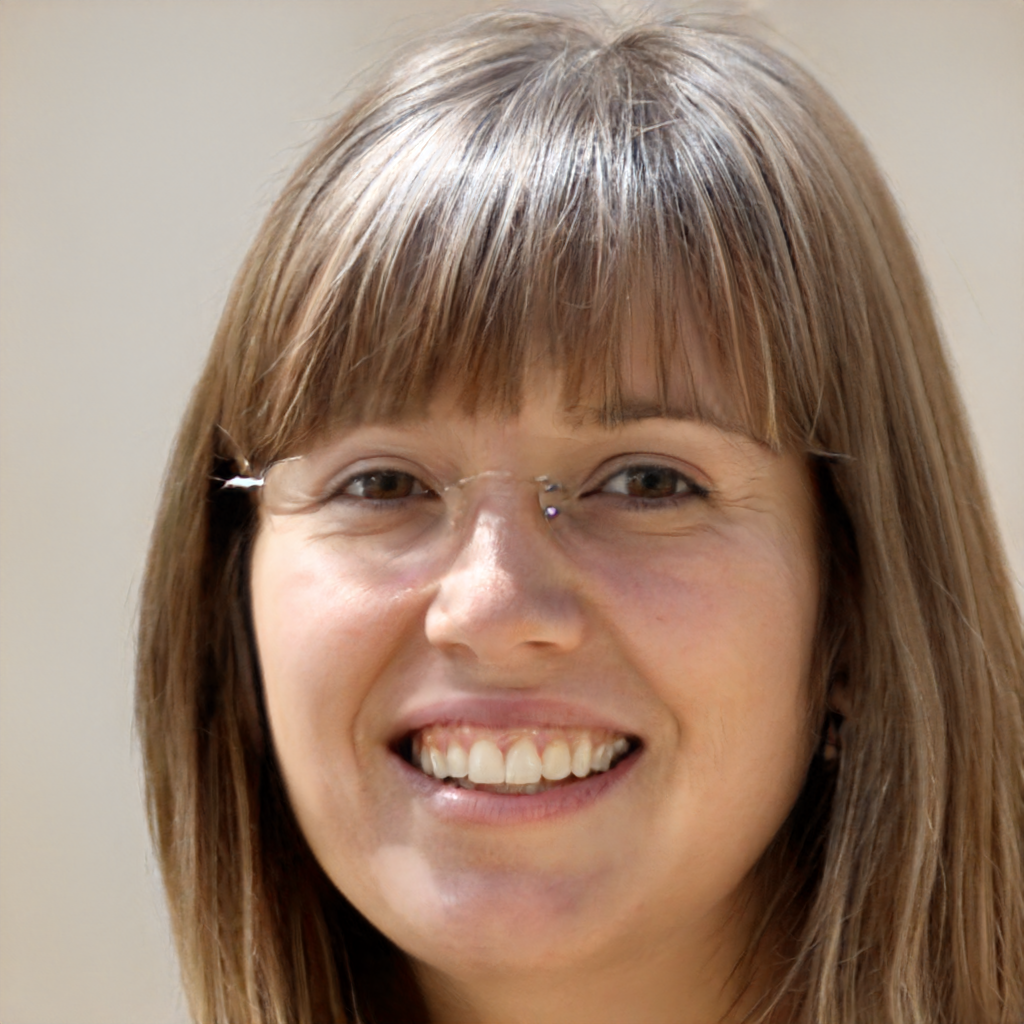

In [24]:
z = torch.randn([1, G.z_dim]).to(device)
img = G(z, None)

imshow((img*0.5+0.5).clamp(0,1).squeeze().permute(1,2,0).cpu().numpy())